# NLP Project : Story generator from event and character embedding to construct interactive story

## Import

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "theotimbarbier"
os.environ['KAGGLE_KEY'] = "f42b2359b5cef90c532db13949cdabfb"

!kaggle datasets download -d ratthachat/writing-prompts

Dataset URL: https://www.kaggle.com/datasets/ratthachat/writing-prompts
License(s): other
writing-prompts.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!unzip writing-prompts.zip

Archive:  writing-prompts.zip
replace writingPrompts/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
!pip install torch
!pip install pyarrow
!pip install datasets
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import pandas as pd
import numpy as np
from collections import defaultdict
import math
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import spacy
from gensim.models import Word2Vec
import gensim
from nltk import translate as tr
import random
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1) data handling

In [5]:
with open("writingPrompts/train.wp_target") as f:
  stories = f.readlines()

In [6]:
with open("writingPrompts/train.wp_source") as f:
  prompts = f.readlines()

In [7]:
N = 150

In [8]:
indexes = random.sample(range(len(stories)), k=N)

In [9]:
handledStories = [stories[i] for i in indexes]
handledPrompts = [prompts[i] for i in indexes]

In [10]:
handledPrompts[0]

'[ WP ] Sunflowers are now sinflowers ; every time you commit one of the seven sins , a sinflower grows on your lawn . Your neighbor just moved in and their yard is full of these flowers . They invite you over for dinner .\n'

In [11]:
handledStories[0]

"`` It 's for stealing , I bet , '' Susan said with a not-so-subtle nod to the yellow flowers waving in the breeze . `` I saw the movers carrying in a box full of toys , including a skateboard . I bet they have a little monster who will go around destroying the whole neighborhood . Graffiti , drugs… who knows ? '' She swirled her glass of lemonade with her straw ; even from here I could smell the pungent tang of whatever booze she 'd spiked it with . As Susan spoke , her eyes kept darting across the porch like she was afraid the new family might be watching and listening from all the way across the street . <newline> <newline> Carolyn disagreed . `` They 're perverts , '' she declared in the most certain tone despite having never even met any member of the family . `` Who knows what kind of sick things they 're doing in there ? *Normal* people do n't get a yard full of sinflowers within a week . It 's disgusting . What do you think , Connie ? '' <newline> <newline> I kept my mouth shut

We remove the useless terms

In [12]:
termsToRemove = {"<newline>", ".\n", "?\n", "!\n", "...\n", "[ WP ]"}

In [13]:
processedStories = []
for story in handledStories:
  for term in termsToRemove:
    story = story.replace(term, "")
  processedStories.append(story)

In [14]:
processedPrompts = []
for prompt in handledPrompts:
  for term in termsToRemove:
    prompt = prompt.replace(term, "")
  processedPrompts.append(prompt)

In [15]:
nbTrain = int(0.8 * N)

In [16]:
trainProcessedPrompts = processedPrompts[:nbTrain]
trainProcessedStories = processedStories[:nbTrain]

In [17]:
testProcessedPrompts = processedPrompts[nbTrain:]
testProcessedStories = processedStories[nbTrain:]

## 2) Event creation

The basic event definition is define, as in paper *Event Representations for Automated Story Generation with Deep Neural Nets* : e = <s,v,o,m> with s the subject, v the verb, o the object and m an optional modifier.

First we create an Event class :

In [18]:
class Event:
  def __init__(self, subject = None, verb = None, o = None, modifier = None):
    self.subject = subject
    self.verb = verb
    self.obj = o
    self.modifier = modifier

  def toString(self):
    return str(self.subject) + ", " + str(self.verb) + ", " + str(self.obj) + ", " + str(self.modifier)

  def toStringNoComa(self):
    return str(self.subject) + " " + str(self.verb) + " " + str(self.obj) + " " + str(self.modifier)

  def toList(self):
    return [self.subject, self.verb, self.obj, self.modifier]


Then we create a tokenizer which allow us to recover the part of speech of the tokens and the dependencies. We use spacy to do that.

In [19]:
nlp = spacy.load("en_core_web_lg")

In [20]:
def tokenizer(text):
    return [x for x in nlp(text) if x.pos_ not in {'PUNCT', 'CCONJ', 'DET', 'SYM', 'X'}]

In [21]:
for sent in nlp(processedStories[0]).sents:
  for token in sent:
    print(token.head)

's
's
's
said
's
for
stealing
bet
's
said
said
said
said
said
nod
subtle
subtle
subtle
subtle
nod
with
nod
flowers
flowers
to
flowers
waving
breeze
in
said
saw
saw
saw
saw
movers
carrying
saw
carrying
box
in
box
full
of
box
box
skateboard
including
saw
bet
bet
have
bet
monster
monster
have
go
go
monster
go
go
neighborhood
neighborhood
destroying
bet
Graffiti
Graffiti
Graffiti
Graffiti
knows
Graffiti
Graffiti
Graffiti
swirled
smell
glass
swirled
glass
of
swirled
straw
with
smell
from
smell
from
smell
smell
smell
tang
tang
smell
tang
booze
of
spiked
spiked
tang
spiked
spiked
smell
spoke
spoke
kept
kept
eyes
kept
kept
kept
darting
porch
across
was
was
darting
was
family
family
watching
watching
watching
afraid
watching
watching
listening
way
way
across
from
street
across
kept
.
disagreed
disagreed
disagreed
're
're
're
declared
're
declared
declared
declared
declared
declared
tone
certain
tone
in
declared
met
met
met
despite
member
met
member
family
of
declared
knows
knows
knows
knows
kin

List of possible subject, dependencies, verbs, and modifier in spacy that are intesting for our purpose

In [22]:
subjTypes = ("nsubj", "csubj", "nsubjpass", "csubjpass")

In [23]:
verbTypes = {"AUX", "VERB"}

In [24]:
objTypes = {"dobj", "attr"}

In [25]:
modTypes = {"iobj", "pobj", "ccomp", "xcomp", "amod","nmod", "npmod", "advcl"}

In [26]:
def searchVerbsDependencies(verb, verbList):
  objects = []
  modifier = []
  for t in verb.children:
    if not(t.pos_ in verbTypes):
      if (t.dep_ in objTypes):
        objects.append(t)
      if t.dep_ in modTypes:
        modifier.append(t)
    else:
      searchVerbsDependencies(t, verbList)
  verbList.append([verb, objects, modifier])
  return verbList

In [27]:
def eventCreator(story):
  event2Sent = {}
  totalEventList = []
  for sent in nlp(story).sents:
    eventList = []
    for token in sent:
      #create an event from a subject
      if token.dep_ in subjTypes:
        subj = token
        verb = subj.head
        if verb.pos_ in verbTypes:
          verbList = []
          verbList = searchVerbsDependencies(verb, verbList)

          for v in verbList:
            if len(v[1]) == 0:
              for m in v[2]:
                eventList.append(Event(subj.lemma_, v[0].lemma_, "NoObject", m.lemma_))
            elif len(v[2]) == 0:
              for o in v[1]:
                eventList.append(Event(subj.lemma_, v[0].lemma_, o.lemma_, "NoObject"))
            else:
              for o in v[1]:
                for m in v[2]:
                  eventList.append(Event(subj.lemma_, v[0].lemma_, o.lemma_, m.lemma_))
      for event in eventList:
        event2Sent[event] = sent.text
    totalEventList += eventList
  return event2Sent, totalEventList


In [28]:
processedPrompts[0]

' Sunflowers are now sinflowers ; every time you commit one of the seven sins , a sinflower grows on your lawn . Your neighbor just moved in and their yard is full of these flowers . They invite you over for dinner '

In [29]:
event2Sent, eventList = eventCreator(processedStories[0])

In [30]:
for event in eventList:
  print(event.toList())

['I', 'have', 'monster', 'NoObject']
['they', 'have', 'monster', 'NoObject']
['who', 'destroy', 'neighborhood', 'NoObject']
['she', 'swirl', 'glass', 'NoObject']
['I', 'swirl', 'glass', 'NoObject']
['I', 'smell', 'tang', 'NoObject']
['she', 'spike', 'it', 'NoObject']
['they', 'be', 'pervert', 'NoObject']
['she', 'be', 'pervert', 'NoObject']
['who', 'know', 'NoObject', 'kind']
['people', 'get', 'yard', 'NoObject']
['you', 'think', 'what', 'NoObject']
['I', 'keep', 'mouth', 'NoObject']
['both', 'keep', 'set', 'NoObject']
['Carolyn', 'have', 'need', 'NoObject']
['it', 'be', 'none', 'NoObject']
['I', 'be', 'none', 'NoObject']
['we', 'learn', 'more', 'NoObject']
['that', 'end', 'conversation', 'NoObject']
['Carolyn', 'trade', 'look', 'NoObject']
['Susan', 'do', 'this', 'NoObject']
['Susan', 'say', 'goodbyes', 'complete']
['we', 'do', 'this', 'NoObject']
['we', 'spend', 'time', 'NoObject']
['it', 'roll', 'eye', 'NoObject']
['it', 'take', 'all', 'NoObject']
['be', 'roll', 'eye', 'NoObject']
[

We now create all the event in our story and prompts

In [31]:
def createEventsFromPrompts(prompts):
  promptEvents = []
  promptEvent2Sent = {}
  for prompt in prompts:
    eventDict, eventList = eventCreator(prompt)
    promptEvents.append(eventList)
    promptEvent2Sent.update(eventDict)
  return promptEvent2Sent, promptEvents

def createEventsFromStories(stories):
  storiesEvents = []
  storiesEvent2Sent = {}
  for story in stories:
    eventDict, eventList = eventCreator(story)
    storiesEvents.append(eventList)
    storiesEvent2Sent.update(eventDict)
  return storiesEvent2Sent, storiesEvents

In [32]:
trainPromptEvent2Sent, trainPromptsEvents = createEventsFromPrompts(trainProcessedPrompts)
trainStoriesEvent2Sent, trainStoriesEvents = createEventsFromStories(trainProcessedStories)

In [33]:
#print(trainPromptsEvents[10][1].toString())

In [34]:
nb = 0
for events in trainPromptsEvents:
  nb += len(events)
print(nb)

205


In [35]:
nb = 0
for events in trainStoriesEvents:
  nb += len(events)
print(nb)

5581


In [36]:
testPromptEvent2Sent, testPromptsEvents = createEventsFromPrompts(testProcessedPrompts)
testStoriesEvent2Sent, testStoriesEvents = createEventsFromStories(testProcessedStories)

## 3) Character Embedding

We use the name entity recognition to find character and we consider the related verbs and adjectives to this character as in work : *A Character-Centric Neural Model for Automated Story Generation*

In [37]:
processedStories[0]

"`` It 's for stealing , I bet , '' Susan said with a not-so-subtle nod to the yellow flowers waving in the breeze . `` I saw the movers carrying in a box full of toys , including a skateboard . I bet they have a little monster who will go around destroying the whole neighborhood . Graffiti , drugs… who knows ? '' She swirled her glass of lemonade with her straw ; even from here I could smell the pungent tang of whatever booze she 'd spiked it with . As Susan spoke , her eyes kept darting across the porch like she was afraid the new family might be watching and listening from all the way across the street .   Carolyn disagreed . `` They 're perverts , '' she declared in the most certain tone despite having never even met any member of the family . `` Who knows what kind of sick things they 're doing in there ? *Normal* people do n't get a yard full of sinflowers within a week . It 's disgusting . What do you think , Connie ? ''   I kept my mouth shut . It would have been so easy to poi

In [38]:
sent = tokenizer(processedStories[0])

In [39]:
entityToRemove = {'O'}
entityTypeToRemove = {'DATE', 'CARDINAL', 'ORDINAL', 'TIME'}

In [40]:
for token in sent:
  if (not(token.ent_iob_ in entityToRemove)) and (not(token.ent_type_ in entityTypeToRemove)):
    print(token.ent_iob_)
    print(token.ent_type_)
    print(token)

B
PERSON
Susan
B
PERSON
Graffiti
B
PERSON
Susan
B
PERSON
Carolyn
B
PERSON
Connie
B
PERSON
Carolyn
B
PERSON
Paul
B
PERSON
Carolyn
B
PERSON
Susan
B
PERSON
Kara
B
PERSON
Susan
B
PERSON
Susan
B
PERSON
Carolyn
B
PERSON
Alan
B
QUANTITY
At
I
QUANTITY
least
I
QUANTITY
six
I
QUANTITY
feet
B
PERSON
Connie
B
PERSON
Susan
B
PERSON
Carolyn
I
PERSON
s
B
PERSON
Alan
B
PERSON
Alan
B
PERSON
Kara
B
PERSON
Kara
B
PERSON
Alan
B
PERSON
Alan
I
PERSON
s


In [41]:
def getCharacterEmbedding(corpus):
  characterSet = set()
  for text in corpus:
    tokens = tokenizer(text)
    #search for characters with spacy ner
    for token in tokens:
      if (not(token.ent_iob_ in entityToRemove)) and (not(token.ent_type_ in entityTypeToRemove)):
        characterSet.add(token.lemma_)
      elif (token.lemma_ == "I") or (token.lemma_ == "you"):
        characterSet.add(token.lemma_)
  #create character dict to store word related to characters
  characterDict = dict()
  for character in characterSet:
    characterDict[character] = []

   #search for word related to character
  for text in corpus:
    tokens = nlp(text)
    for token in tokens:
      if (token.lemma_ in characterSet):
        if (token.head.pos_ == 'VERB') or (token.head.pos_ == 'ADJ') or (token.head.pos_ == 'NOUN'):
          characterDict[token.lemma_].append(token.head.lemma_)
        if (token.head.pos_ == 'AUX') or (token.head.pos_ == 'NOUN'):
          for t in token.head.children:
            if (t.pos_ == 'ADJ'):
              characterDict[token.lemma_].append(t.lemma_)
      elif (token.head.lemma_ in characterSet):
        if (token.pos_ == 'VERB') or (token.pos_ == 'ADJ') or (token.head.pos_ == 'NOUN'):
          characterDict[token.head.lemma_].append(token.lemma_)
  return characterDict


In [42]:
c = getCharacterEmbedding(processedPrompts)

In [43]:
c

{'say': ['say', 'laugh', 'say', 'come'],
 'arctic': ['tundra', 'arctic'],
 "'s": ['old', 'character', 'character', 'man', 'dead'],
 'Lovecraft': [],
 'Tolkien': [],
 'Writers': [],
 'Woolly': [],
 'Service': ['agent'],
 'Joker': ['trouble'],
 'Dragons': [],
 'Democratic': [],
 'Pratchett': [],
 'Eleven': [],
 'Osama': [],
 'video': ['game', 'last', 'log'],
 'you': ['commit',
  'invite',
  'die',
  'curse',
  'find',
  'wake',
  'hand',
  'tell',
  'wake',
  'reel',
  'give',
  'receive',
  'don',
  'go',
  'die',
  'find',
  'present',
  'know',
  'move',
  'drag',
  'run',
  'interested',
  'summon',
  'go',
  'impress',
  'execute',
  'go',
  'try',
  'last',
  'first',
  'inherit',
  'enter',
  'remember',
  'fast',
  'transfer',
  'awaken',
  'cover',
  'look',
  'decide',
  'kill',
  'cross',
  'use',
  'use',
  'live',
  'become',
  'have',
  'have',
  'hear',
  'have',
  'require',
  'leave',
  'watch',
  'find',
  'keep',
  'get',
  'select',
  'recognize',
  'commit',
  'die',

In [44]:
sent = tokenizer("I am groot")

In [45]:
sent[0].lemma_ == "I"

True

## 4) Event2Event

### creation of the vocabulary

We need to create our vocabulary (inspired by pytorch RNN creation and lecture)

In [46]:
class Vocab:
    def __init__(self, name):
        self.name = name
        self.word2index = {"NoObject": 0}
        self.word2count = {"NoObject": 1}
        self.index2word = {0: "NoObject"}
        self.n_words = 1
        self.count = 1

    def addSentence(self, sentence):
        for word in tokenizer(sentence):
            self.addWord(word.lemma_)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
            self.count += 1
        else:
            self.word2count[word] += 1
            self.count += 1

In [47]:
vocab = Vocab('vocabulary')

In [48]:
for story in processedStories:
    vocab.addSentence(story)
for prompt in processedPrompts:
    vocab.addSentence(prompt)

In [49]:
print(vocab.name + " size : " + str(vocab.n_words))

vocabulary size : 7884


### creation of the pairs as input and target

And then our pair of 2 sucessives events :

In [50]:
trainPairsEvent = []
for j in range(len(trainPromptsEvents)):
    concat = trainPromptsEvents[j] + trainStoriesEvents[j]
    for i in range(len(concat) - 1):
        trainPairsEvent.append([concat[i],concat[i+1]])

In [51]:
print(trainPairsEvent[20][0].toString() + " -> " + trainPairsEvent[20][1].toString())

I, be, none, NoObject -> we, learn, more, NoObject


In [52]:
len(trainPairsEvent)

5666

In [53]:
testPairsEvent = []
for j in range(len(testPromptsEvents)):
    concat = testPromptsEvents[j] + testStoriesEvents[j]
    for i in range(len(concat) - 1):
        testPairsEvent.append([concat[i],concat[i+1]])

In [54]:
eventVocab = Vocab('eventVocab')
for pair in trainPairsEvent:
    for token in pair[0].toList():
        if not(token == "NoObject"):
            eventVocab.addWord(token)
    for token in pair[1].toList():
        if not(token == "NoObject"):
            eventVocab.addWord(token)
for pair in testPairsEvent:
    for token in pair[0].toList():
        if not(token == "NoObject"):
            eventVocab.addWord(token)
    for token in pair[1].toList():
        if not(token == "NoObject"):
            eventVocab.addWord(token)

In [55]:
eventVocab.word2index

{'NoObject': 0,
 'sunflower': 1,
 'be': 2,
 'sinflower': 3,
 'you': 4,
 'commit': 5,
 'one': 6,
 'they': 7,
 'invite': 8,
 'I': 9,
 'have': 10,
 'monster': 11,
 'who': 12,
 'destroy': 13,
 'neighborhood': 14,
 'she': 15,
 'swirl': 16,
 'glass': 17,
 'smell': 18,
 'tang': 19,
 'spike': 20,
 'it': 21,
 'pervert': 22,
 'know': 23,
 'kind': 24,
 'people': 25,
 'get': 26,
 'yard': 27,
 'think': 28,
 'what': 29,
 'keep': 30,
 'mouth': 31,
 'both': 32,
 'set': 33,
 'Carolyn': 34,
 'need': 35,
 'none': 36,
 'we': 37,
 'learn': 38,
 'more': 39,
 'that': 40,
 'end': 41,
 'conversation': 42,
 'trade': 43,
 'look': 44,
 'Susan': 45,
 'do': 46,
 'this': 47,
 'say': 48,
 'goodbyes': 49,
 'complete': 50,
 'spend': 51,
 'time': 52,
 'roll': 53,
 'eye': 54,
 'take': 55,
 'all': 56,
 'neighbor': 57,
 'leave': 58,
 'porch': 59,
 'bash': 60,
 'elm': 61,
 'change': 62,
 'color': 63,
 'house': 64,
 'whirring': 65,
 'line': 66,
 'street': 67,
 'sound': 68,
 'make': 69,
 'door': 70,
 'man': 71,
 'contact': 72

### creation of the data batches

In [56]:
def indexesFromEvent(v, event):
    oneHotList = []
    for word in event.toList():
        if word in v.word2index.keys():
          oneHotList.append(v.word2index[word])
        else:
          oneHotList.append(0)
    return oneHotList


def tensorFromEvent(v, event):
    indexes = indexesFromEvent(v, event)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(v, pair):
    input_tensor = tensorFromEvent(v, pair[0])
    target_tensor = tensorFromEvent(v, pair[1])
    return (input_tensor, target_tensor)

def sentenceFromTensor(v, tensor):
    sentence = []
    for index in tensor:
        sentence.append(v.index2word[int(index)])
    return sentence

In [57]:
print(trainPairsEvent[0][0].toString())

sunflower, be, sinflower, NoObject


In [58]:
t1, t2 = tensorsFromPair(eventVocab, trainPairsEvent[0])

In [59]:
print(t1)

tensor([[1],
        [2],
        [3],
        [0]])


In [60]:
def get_dataloader(batch_size, pairs, vocab):

    n = len(pairs)
    input_ids = np.zeros((n, 4), dtype=np.int32)
    target_ids = np.zeros((n, 4), dtype=np.int32)

    for idx, pair in enumerate(pairs):
        inp_tensor, tgt_tensor = tensorsFromPair(vocab, pair)

        input_ids[idx, :len(inp_tensor)] = inp_tensor.squeeze()
        target_ids[idx, :len(tgt_tensor)] = tgt_tensor.squeeze()

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return train_dataloader

In [61]:
batch_size = 32

In [62]:
trainDL = get_dataloader(batch_size, trainPairsEvent[:500], eventVocab)

In [63]:
train_features, train_labels = next(iter(trainDL))
print(train_features[0])
print(train_labels[0])

tensor([  4, 166, 125,   0])
tensor([  4, 184,   9,   0])


### creation of the model

And we create a simple RNN encoder-decoder in order to predict the next event with the previous event.

In [64]:
class RNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input_tensor, hidden):
        combined = torch.cat((input_tensor, hidden), 1)
        hidden = self.i2h(combined)
        return hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [65]:
class RNNDecoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(RNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, hidden):
        hidden = self.h2h(hidden)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden


### Training

We use log likelihood to train the model. We get the input as the one hot encoding of the word (vector of size vocab) and get a vector of probability over the vocabulary as output (vector of size vocab)

In [66]:
loss = nn.NLLLoss()

Then we define the train function as in seq2seq classic tutorial

As in the paper we define functions to keep tracking of the time computation

In [67]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The function to plot the plot of the loss in the training

In [68]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

and the function to train the model on our data

In [69]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for batch in dataloader:
      for i in range(len(batch)):
        input_tensor  = batch[0][i]
        target_tensor = batch[1][i]

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        hidden_tensor = encoder.init_hidden()

        for inp in input_tensor:
            hidden_tensor = encoder(inp.view(1,1), hidden_tensor)

        outputs_tensor = torch.zeros(len(target_tensor),decoder.output_size)

        for trt in range(len(target_tensor)):
            output_tensor, hidden_tensor = decoder(hidden_tensor)
            outputs_tensor[trt] = output_tensor

        #print(outputs_tensor)
        loss = criterion(
            outputs_tensor,
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [70]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=25, plot_every=25):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=50, gamma=0.5)
    decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=50, gamma=0.5)

    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer,  criterion)
        print_loss_total += loss
        plot_loss_total += loss

        encoder_scheduler.step()
        decoder_scheduler.step()

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Training on our data

0m 14s (- 9m 31s) (25 2%) 9.4697
0m 26s (- 8m 22s) (50 5%) 7.4010
0m 39s (- 8m 12s) (75 7%) 6.6635
0m 53s (- 8m 5s) (100 10%) 6.4002
1m 7s (- 7m 50s) (125 12%) 6.1202
1m 20s (- 7m 38s) (150 15%) 5.9358
1m 35s (- 7m 28s) (175 17%) 5.7530
1m 53s (- 7m 32s) (200 20%) 5.6916
2m 7s (- 7m 19s) (225 22%) 5.6113
2m 19s (- 6m 59s) (250 25%) 5.6124
2m 38s (- 6m 56s) (275 27%) 5.5122
2m 52s (- 6m 41s) (300 30%) 5.3781
3m 7s (- 6m 29s) (325 32%) 5.5171
3m 19s (- 6m 10s) (350 35%) 5.4392
3m 35s (- 5m 58s) (375 37%) 5.4003
3m 46s (- 5m 39s) (400 40%) 5.3438
4m 0s (- 5m 25s) (425 42%) 5.3671
4m 12s (- 5m 8s) (450 45%) 5.3620
4m 28s (- 4m 56s) (475 47%) 5.3852
4m 39s (- 4m 39s) (500 50%) 5.4421
4m 54s (- 4m 26s) (525 52%) 5.3776
5m 5s (- 4m 9s) (550 55%) 5.3883
5m 20s (- 3m 56s) (575 57%) 5.4582
5m 32s (- 3m 41s) (600 60%) 5.4026
5m 44s (- 3m 26s) (625 62%) 5.4413
5m 57s (- 3m 12s) (650 65%) 5.3575
6m 10s (- 2m 58s) (675 67%) 5.3403
6m 24s (- 2m 44s) (700 70%) 5.3585
6m 36s (- 2m 30s) (725 72%) 5.4132

<Figure size 640x480 with 0 Axes>

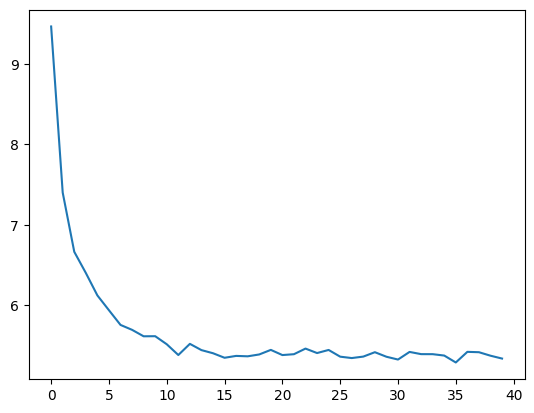

In [71]:
hidden_size = 200
encoder1 = RNNEncoder(1, hidden_size).to(device)
decoder1 = RNNDecoder(hidden_size, eventVocab.n_words).to(device)

train(trainDL,encoder1, decoder1, 1000)

### evaluation

In [72]:
def makePrediction(input_tensor):
    encoder_hidden = encoder1.init_hidden()
    input_length = input_tensor.size(0)

    for ei in range(input_length):
        encoder_hidden = encoder1(input_tensor[ei].view(1,1), encoder_hidden)

    decoder_input = torch.zeros(input_length, device=device)
    decoder_hidden = encoder_hidden
    decoder_outputs = torch.zeros(input_length, dtype=torch.long, device=device)

    #every target is of size 4 so target_length = 4
    for di in range(4):
        decoder_output, decoder_hidden = decoder1(decoder_hidden)
        topv, topi = decoder_output.topk(1) #return the largest element of the tensor
        decoder_input = topi.squeeze().detach()  # detach from history as input
        decoder_outputs[di] = topi.long()
    return decoder_outputs

def makePredictionFromPair(pairEvent):
    input_tensor, target_tensor = tensorsFromPair(eventVocab, pairEvent)
    return makePrediction(input_tensor)


In [73]:
ex = 30
d = makePredictionFromPair(testPairsEvent[ex])
print(d)
d = d.tolist()
s = sentenceFromTensor(eventVocab, d)

tensor([ 9,  2, 29,  0])


In [74]:
d

[9, 2, 29, 0]

In [75]:
s

['I', 'be', 'what', 'NoObject']

In [76]:
testPairsEvent[ex][0].toString()

'I, say, what, NoObject'

In [77]:
testPairsEvent[ex][1].toString()

'I, pay, attention, NoObject'

To evaluate our model, we use 2 metrics :


*   Perplexity over unigrams
*   BiLingual Evaluation Understudy(BLEU)



In [78]:
def wordProba(word, vocab):
    if word in vocab.word2count.keys():
      output = vocab.word2count[word] / vocab.count
    else:
      output = 1e-6
    return output

In [79]:
def perplexity(sentence, vocab):
    temp = 0
    for word in sentence:
        p = wordProba(word, vocab)
        temp += p * math.log2(p)
    return math.pow(2, -temp)

In [80]:
perplexity(s, eventVocab)

1.573126431780259

In [81]:
perplexity(testPairsEvent[ex][1].toList(), eventVocab)

1.2617538629338059

In [82]:
#test set is a list of pair of event

def evaluateEventPerplexity(testSet, vocab):
    perplexityScore = 0
    for pair in testSet:
        prediction = sentenceFromTensor(vocab, makePredictionFromPair(pair).tolist())
        perplexityScore += perplexity(prediction, vocab)
    return perplexityScore / len(testSet)

In [83]:
perplexityScore = evaluateEventPerplexity(testPairsEvent, eventVocab)

In [84]:
print(perplexityScore)

1.1751136825174888


In [85]:
def evaluateBLEU(testSet):
    total_bleu_score = 0
    for pair in testSet:
        prediction = sentenceFromTensor(vocab, makePredictionFromPair(pair).tolist())
        bleu_score = tr.bleu_score.sentence_bleu([pair[1].toList()], prediction, smoothing_function=tr.bleu_score.SmoothingFunction().method1)
        total_bleu_score += bleu_score

    return total_bleu_score / len(testSet)


In [86]:
average_bleu_score = evaluateBLEU(testPairsEvent)
print(f"Average BLEU Score: {average_bleu_score}")

Average BLEU Score: 0.03297039253936232


## 5) Event2Sentence

Now that we can generate next event, we need to be able to generate sentences from event. To do so, we use a special transformer model that we fine tune with our event and sentence training set. In our case, we use BART model which contains a BERT encoder (bidirectional) and a GPT decoder (left ot right).

### Dataset creation

First, we create our complete training set which consist of a dictionnary of event and associated sentence that we put in a dataset :

In [87]:
trainEvent2Sent = {**trainPromptEvent2Sent,**trainStoriesEvent2Sent}

In [88]:
maxExemples = 200

In [89]:
ind = random.choices(list(trainEvent2Sent.keys()), k=maxExemples)
trainEvent2SentHandle = {}
for i in ind:
  trainEvent2SentHandle[i] = trainEvent2Sent[i]

In [90]:
trainEvent2SentList = []
for event in trainEvent2SentHandle.keys():
  trainEvent2SentList += [{"input": event.toStringNoComa(), "output": trainEvent2SentHandle[event]}]

trainDataset = Dataset.from_list(trainEvent2SentList)


In [91]:
print(trainDataset['output'][0])

Being the taxi service for lost souls was no fun anymore , after years of pleading for mercy before being sent into the pits of hell , he hoped to find someone who would n't beg him for mercy , that 's where his Demon virtues ran out .


And we tokenize the inputs and output with BART tokenizer to preprocess our data to fit in BART model :

In [92]:
# Load the BART tokenizer
tokenizerBART = BartTokenizer.from_pretrained('facebook/bart-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [93]:
# Tokenize the data
def preprocess_function(example):
    inputs = example["input"]
    targets = example["output"]
    model_inputs = tokenizerBART(inputs, max_length=10, truncation=True, padding="max_length")

    # Set up the tokenizer for targets
    labels = tokenizerBART(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenizedTrainDataset = trainDataset.map(preprocess_function, batched=False)

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

### Model and training

We use the seq2seq BART model that we fine tune with our training data :

In [94]:


# Load the BART model
event2SentModel = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

# Set up training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Set up the Trainer
trainer = Seq2SeqTrainer(
    model=event2SentModel,
    args=training_args,
    train_dataset=tokenizedTrainDataset,
)

# Fine-tune the model
trainer.train()


Step,Training Loss
10,14.949900
20,14.072400
30,13.099500
40,12.029300
50,11.517500
60,10.751100
70,10.000100


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=75, training_loss=12.137869822184244, metrics={'train_runtime': 1353.5426, 'train_samples_per_second': 0.439, 'train_steps_per_second': 0.055, 'total_flos': 3536947814400.0, 'train_loss': 12.137869822184244, 'epoch': 3.0})

### Prediction

In [95]:
def generate_output(input_text):
    inputs = tokenizerBART(input_text, return_tensors="pt", padding="max_length", max_length=10, truncation=True)
    outputs = event2SentModel.generate(inputs["input_ids"], max_length=50)
    output_text = tokenizerBART.decode(outputs[0], skip_special_tokens=True)
    return output_text

# Example usage
input_event = testPairsEvent[0][1].toStringNoComa()
output_sentence = generate_output(input_event)
print(output_sentence)

All they had to do was hold their hands and handed them over to them, they said they had no idea what to do with them and they all had to go back to their places and put them back where they belonged to them All


In [96]:
print(testPairsEvent[0][1].toStringNoComa())

it do they NoObject


### Evalutation

We use again the perplexity and BLEU metrics to evaluate our event2sentence model :

In [97]:
def evaluateSentencePerplexity(testSet, vocab):
    perplexityScore = 0
    for event in testSet.keys():
        prediction = generate_output(event.toStringNoComa())
        perplexityScore += perplexity(prediction, vocab)
    return perplexityScore / len(testSet)

In [98]:
testEvent2Sent = {**testPromptEvent2Sent,**testStoriesEvent2Sent}

In [99]:
ind = random.choices(list(testEvent2Sent.keys()), k=int(maxExemples*0.2))
testEvent2SentHandle = {}
for i in ind:
  testEvent2SentHandle[i] = testEvent2Sent[i]

In [100]:
perp = evaluateSentencePerplexity(testEvent2SentHandle, vocab)

In [101]:
print(perp)

2.2169382327246394


For BLEU, it would be better to use only references sentences that are created from the same event. But here, we lack of a good training set that would give enough sentences for the same event to give a relevant score (at least we lack of a relevant number of examples that we can process on my computer). Then we use only one reference to compute the BLEU score.

In [102]:
def evaluateBLEU(testSet):
    total_bleu_score = 0
    for event in testSet.keys():
        prediction = generate_output(event.toStringNoComa())
        bleu_score = tr.bleu_score.sentence_bleu([testSet[event]], prediction, smoothing_function=tr.bleu_score.SmoothingFunction().method1)
        total_bleu_score += bleu_score

    return total_bleu_score / len(testSet)


In [103]:
average_bleu_score = evaluateBLEU(testEvent2SentHandle)
print(f"Average BLEU Score: {average_bleu_score}")

Average BLEU Score: 0.11100920541875847


## 6) Combining event2event with event2sentence

Now we can try to combine our two model to create a logical story.

### prediction

In [104]:
startSent = "I am a dangerous wizard"
eventVocab.addSentence(startSent)
print(startSent)
_, startEvents = eventCreator(startSent)
startEvent = startEvents[0]
storyLength = 10
inputTensor = tensorFromEvent(eventVocab, startEvent)
for i in range(storyLength):
  outputTensor = makePrediction(inputTensor)
  strEvent = sentenceFromTensor(eventVocab, outputTensor)
  strEvent = " ".join(strEvent)
  outputSentence = generate_output(strEvent)
  print(outputSentence)
  inputTensor = outputTensor


I am a dangerous wizard
I will be I No.
He would be glad to be rid of all of them, he said.  Â   
I be what I was, I be what he was  
I be what I am, I be all all of them.   
I be what I wish I could be...   Â
I be what I said I wanted to be and I was right.
 he said, "I had no choice in what I had to do... " he said,,, and,.,, or,,.., or �,,.", ", or..."
I be a little surprised at what I was told.
I be what I was. I be who I am. I am who I was...
I be what I am, and I be who I am.


In [105]:
def storyGeneration(vocab, startSentence, storyLength):
    vocab.addSentence(startSentence)
    outputStory = startSentence
    _, startEvents = eventCreator(startSentence)
    startEvent = startEvents[0]
    inputTensor = tensorFromEvent(vocab, startEvent)
    outputEvents = startEvent.toStringNoComa()
    for i in range(storyLength):
        outputStory += '\n'
        outputTensor = makePrediction(inputTensor)
        strEvent = sentenceFromTensor(vocab, outputTensor)
        strEvent = " ".join(strEvent)
        outputEvents += ' ' + strEvent
        outputSentence = generate_output(strEvent)
        outputStory += outputSentence
        inputTensor = outputTensor
    return outputEvents, outputStory

In [106]:
events, story = storyGeneration(eventVocab,'earth is a red egg', 20)

In [107]:
print(events)

earth be egg NoObject department laugh little less I contradict other NoObject I spy torture NoObject I catch job NoObject I be pamphlet NoObject I spend life NoObject I be I NoObject I be glass NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject I be what NoObject


In [108]:
print(story)

earth is a red egg
department store clerkships iced tea iced water   iced up iced iced over iced cold iced hot iced chapped iced ice iced salt iced skied water iced mint iced
I contradict myself.
I was told that I had to do something I could not do again. I was forced to put up with it.
I thought I had done a good job, and I was happy to be here.
I was stunned by the response I got. I thought that was the answer I wanted. I was wrong.
ug-handed or izlifted iz ipipiplawed  ips   `  ip ip- ips-  iced- ip ­ ip­  � 
I am not a man. I am a man...
I can't stand to be left alone in the dark.   
I be who I am and I will be what I am. 
"I'm not sure I am," he said.
I be what I said I be what i be.
I knew I was doing what I was supposed to do.
I was held to be held down in the mowed down by the Holy gram   I was held down to be represented by the mout    he was held out as he was being  threatened  . 
I am what I would have done if I had known about them. I was what I had heard about them all th

### evaluation

Once again we use our classical mesure of perplexity to mesure linguistic logic and BLEU to use story logic. A totaly subjective human evaluation is also provided in the report.

need one prompt event as input test and the story as output test

## 7) CEvent

Idea of adding character : add a relevant storyline with changing character embedding along the story.

Now that we have our baseline with event representation for story generation, we will try to add character embedding to our event to enhance the generation of event2event model. We call this model CEvent2CEvent, and we need to define what a Cevent (Character Event) is.

We use again our representation of Event with s the subject, v the verb, o the object and m an optional modifier. But now, we consider that the event can include a character (either the subject or the object). To add this consideration, we can use a new representation of event :
e = (s,v,o,m,c)

with c the embedding of the character. The best way would be to add directly the character embedding instead of the subject or modifier embedding. But by doing that, we need to change our encoder/decoder model and it would be too much costly for the computer to train (need a matrix from vocab dimension to hidden dimension rather than 1$\times$hd). Then we add the character embedding to the end of the event and add each word caracterization of the character as a next world in our RNN encoder. Then, we get an input such that :

$$e = (s,v,o,m,c_1, ..., c_k)$$

where $c_1$ ... $c_k$ are the words for the character embedding.


### Cevent Creation

we now need to create character embedding that grows along the story :

In [109]:
def getCharacterEmbeddingFromTokenizedSentence(tokenizedSentence, previousCharacterDict):
  characterSet = set()
  for token in tokenizedSentence:
    if (not(token.ent_iob_ in entityToRemove)) and (not(token.ent_type_ in entityTypeToRemove)):
      characterSet.add(token.lemma_)
    elif (token.lemma_ == "I") or (token.lemma_ == "you"):
      characterSet.add(token.lemma_)
  #create character dict to store word related to characters
  characterDict = previousCharacterDict
  for character in characterSet:
    if not(character in characterDict.keys()):
      characterDict[character] = []

  #search for word related to character
  for token in tokenizedSentence:
    if (token.lemma_ in characterSet):
      if (token.head.pos_ == 'VERB') or (token.head.pos_ == 'ADJ') or (token.head.pos_ == 'NOUN'):
         characterDict[token.lemma_].append(token.head.lemma_)
      if (token.head.pos_ == 'AUX') or (token.head.pos_ == 'NOUN'):
        for t in token.head.children:
          if (t.pos_ == 'ADJ'):
            characterDict[token.lemma_].append(t.lemma_)
    elif (token.head.lemma_ in characterSet):
      if (token.pos_ == 'VERB') or (token.pos_ == 'ADJ') or (token.head.pos_ == 'NOUN'):
        characterDict[token.head.lemma_].append(token.lemma_)
  return characterDict, characterSet

In [110]:
class CEvent:
  def __init__(self, subject = None, verb = None, o = None, modifier = None, character = None):
    self.subject = subject
    self.verb = verb
    self.obj = o
    self.modifier = modifier
    self.character = character  #list of word defining the character


  def character2String(self):
    output = ''
    for word in self.character:
      output += ", " + word
    return output

  def character2StringNoComa(self):
    output = ''
    for word in self.character:
      output += " " + word
    return output



  def toString(self):
    return str(self.subject) + ", " + str(self.verb) + ", " + str(self.obj) + ", " + str(self.modifier) + self.character2String()

  def toStringNoComa(self):
    return str(self.subject) + " " + str(self.verb) + " " + str(self.obj) + " " + str(self.modifier) + self.character2StringNoComa()

  def toList(self):
    return [self.subject, self.verb, self.obj, self.modifier] + self.character


In [111]:
def fixCharacter(characterSet, characterDict, subj, o):
    if not characterSet:
        character = ['NoObject']
    elif subj.lemma_ in characterSet :
        character = characterDict[subj.lemma_].copy()
    elif o.lemma_ in characterSet:
        character = characterDict[o.lemma_].copy()
    else :
        character = ['NoObject']
    return character



def cEventCreator(story):
  cEvent2Sent = {}
  totalCEventList = []
  characterDict = {}
  for sent in nlp(story).sents:
    cEventList = []
    characterDict, characterSet = getCharacterEmbeddingFromTokenizedSentence(sent, characterDict)
    for token in sent:
      #create an event from a subject
      if token.dep_ in subjTypes:
        subj = token
        verb = subj.head
        if verb.pos_ in verbTypes:
          verbList = []
          verbList = searchVerbsDependencies(verb, verbList)

          for v in verbList:
            if len(v[1]) == 0:
              character = fixCharacter(characterSet, characterDict, subj, subj)
              for m in v[2]:
                cEventList.append(CEvent(subj.lemma_, v[0].lemma_, "NoObject", m.lemma_, character))
            elif len(v[2]) == 0:
              for o in v[1]:
                character = fixCharacter(characterSet, characterDict, subj, o)
                cEventList.append(CEvent(subj.lemma_, v[0].lemma_, o.lemma_, "NoObject", character))
            else:
              for o in v[1]:
                character = fixCharacter(characterSet, characterDict, subj, o)
                for m in v[2]:
                  cEventList.append(CEvent(subj.lemma_, v[0].lemma_, o.lemma_, m.lemma_, character))
      for event in eventList:
        cEvent2Sent[event] = sent.text
    totalCEventList += cEventList
  return event2Sent, totalCEventList


In [112]:
cEvent2Sent, cEventList = cEventCreator(processedStories[10])

In [113]:
processedStories[10]

"Standing on the majestic rooftop of a dead man 's manor his yellow eyes were spying the scene taking place below . Purple cape swirling in the wind , he moved his gaze upward to eye the city left for him ; the city he had sworn to protect when no one else was left to do so .   A surge of glee sent shivers through his thin , chemically bleached body , too exhilarating to contain a cackling laugh , only heard by its person of origin -- a man of vengeance , a man of the night , a man of comedy .   `` Harley , dear , tell me ... Does Mr. Cobblepot have any right sending his goons into Wayne Manor to steal these awfully priceless pieces of art ? '' Asked the cowl-wearing clown in a raspy voice dripping with sarcasm .   A female voice answered through the radio attached to the green , leathery torso of his suit :   `` No sir , Mr. J . The penguin-man surely has no right to the bat 's nicest belongings . ''   `` I did n't think so , my dear . ''   In a swift and daring motion the winged clow

In [114]:
for cEvent in cEventList:
  print(cEvent.toString())

stand, spy, scene, NoObject, NoObject
he, eye, city, NoObject, NoObject
he, move, gaze, NoObject, NoObject
surge, contain, laugh, NoObject, NoObject
surge, send, shiver, NoObject, NoObject
Cobblepot, have, right, NoObject, have
voice, answer, NoObject, sir, NoObject
man, have, right, NoObject, NoObject
clown, catch, air, NoObject, NoObject
mantle, catch, air, NoObject, NoObject
sound, whip, air, NoObject, NoObject
goon, have, time, NoObject, NoObject
heel, crack, skull, NoObject, NoObject
I, know, much, NoObject, tell, think, know, think
avenger, contemplate, future, NoObject, NoObject
I, miss, he, NoObject, tell, think, know, think, miss
Clown, miss, he, NoObject, NoObject
you, be, hero, NoObject
I, know, it, NoObject, tell, think, know, think, miss, know
line, be, quote, NoObject, NoObject
I, see, it, NoObject, tell, think, know, think, miss, know, watch, decide
I, use, it, NoObject, tell, think, know, think, miss, know, watch, decide
I, watch, show, NoObject, tell, think, know, thin

### data train creation

Now that we can create our cEvent and our cEvent2SentenceDict, we need to create cEvent pairs :

In [115]:
def createCEventsFromPrompts(prompts):
  promptCEvents = []
  promptCEvent2Sent = {}
  for prompt in prompts:
    cEventDict, cEventList = cEventCreator(prompt)
    promptCEvents.append(cEventList)
    promptCEvent2Sent.update(cEventDict)
  return promptCEvent2Sent, promptCEvents

def createCEventsFromStories(stories):
  storiesCEvents = []
  storiesCEvent2Sent = {}
  for story in stories:
    cEventDict, cEventList = cEventCreator(story)
    storiesCEvents.append(cEventList)
    storiesCEvent2Sent.update(cEventDict)
  return storiesCEvent2Sent, storiesCEvents

In [116]:
trainPromptCEvent2Sent, trainPromptsCEvents = createCEventsFromPrompts(trainProcessedPrompts)
trainStoriesCEvent2Sent, trainStoriesCEvents = createCEventsFromStories(trainProcessedStories)

In [117]:
testPromptCEvent2Sent, testPromptsCEvents = createCEventsFromPrompts(testProcessedPrompts)
testStoriesCEvent2Sent, testStoriesCEvents = createCEventsFromStories(testProcessedStories)

In [118]:
trainPairsCEvent = []
for j in range(len(trainPromptsCEvents)):
    concat = trainPromptsCEvents[j] + trainStoriesCEvents[j]
    for i in range(len(concat) - 1):
        trainPairsCEvent.append([concat[i],concat[i+1]])

In [119]:
print(trainPairsCEvent[200][0].toString() + " -> " + trainPairsCEvent[200][1].toString())

we, buy, time, NoObject, NoObject -> defender, buy, time, NoObject, NoObject


In [120]:
testPairsCEvent = []
for j in range(len(testPromptsCEvents)):
    concat = testPromptsCEvents[j] + testStoriesCEvents[j]
    for i in range(len(concat) - 1):
        testPairsCEvent.append([concat[i],concat[i+1]])

In [121]:
cEventVocab = Vocab('ceventVocab')
for pair in trainPairsCEvent:
    for token in pair[0].toList():
        if not(token == "NoObject"):
            cEventVocab.addWord(token)
    for token in pair[1].toList():
        if not(token == "NoObject"):
            cEventVocab.addWord(token)
for pair in testPairsCEvent:
    for token in pair[0].toList():
        if not(token == "NoObject"):
            cEventVocab.addWord(token)
    for token in pair[1].toList():
        if not(token == "NoObject"):
            cEventVocab.addWord(token)

In [122]:
maxCEventToken = 25
batch_size = 32

In [123]:
def getDataloaderCevent(batch_size, pairs, vocab):

    n = len(pairs)
    input_ids = np.zeros((n, maxCEventToken), dtype=np.int32)
    target_ids = np.zeros((n, maxCEventToken), dtype=np.int32)

    for idx, pair in enumerate(pairs):
        inp_tensor, tgt_tensor = tensorsFromPair(vocab, pair)

        input_ids[idx, :min(len(inp_tensor),maxCEventToken)] = inp_tensor[:min(len(inp_tensor),maxCEventToken)].squeeze()
        target_ids[idx, :min(len(tgt_tensor),maxCEventToken)] = tgt_tensor[:min(len(tgt_tensor),maxCEventToken)].squeeze()

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    trainDataloaderCevent = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return trainDataloaderCevent

In [124]:
trainDLCevent = getDataloaderCevent(batch_size, testPairsCEvent[:500], cEventVocab)

In [125]:
train_features, train_labels = next(iter(trainDLCevent))
print(train_features[0])
print(train_labels[0])

tensor([   9,  229,   23,    0, 1429,  229,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])
tensor([   9, 2756,   31,    0, 1429,  229, 2757,   61,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0])


### Model for Cevent2Cevent

We take our previous model that we get into one class to make everything clear

In [126]:
class CEvent2CEvent():
  def __init__(self, hidden_size, vocab, maxCEventToken):
    self.encoder = RNNEncoder(1, hidden_size)
    self.decoder = RNNDecoder(hidden_size, vocab.n_words)
    self.maxCEventToken = maxCEventToken


  def train_epoch(self, dataloader, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for batch in dataloader:
      for i in range(len(batch)):
        input_tensor  = batch[0][i]
        target_tensor = batch[1][i]

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        hidden_tensor = self.encoder.init_hidden()

        for inp in input_tensor:
            hidden_tensor = self.encoder(inp.view(1,1), hidden_tensor)

        outputs_tensor = torch.zeros(len(target_tensor),self.decoder.output_size)

        for trt in range(len(target_tensor)):
            output_tensor, hidden_tensor = self.decoder(hidden_tensor)
            outputs_tensor[trt] = output_tensor

        #print(outputs_tensor)
        loss = criterion(outputs_tensor, target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


  def trainModel(self, train_dataloader, n_epochs, learning_rate=0.001, print_every=25, plot_every=25):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=learning_rate)
    encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=50, gamma=0.5)
    decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=50, gamma=0.5)

    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = self.train_epoch(train_dataloader, encoder_optimizer, decoder_optimizer,  criterion)
        print_loss_total += loss
        plot_loss_total += loss

        encoder_scheduler.step()
        decoder_scheduler.step()

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

  def train(self, trainDataLoader, n_epochs):
    self.trainModel(trainDL, n_epochs)


  def makePrediction(self, input_tensor):
    encoder_hidden = self.encoder.init_hidden()
    input_length = input_tensor.size(0)

    for ei in range(input_length):
        encoder_hidden = self.encoder(input_tensor[ei].view(1,1), encoder_hidden)

    decoder_input = torch.zeros(input_length, device=device)
    decoder_hidden = encoder_hidden
    decoder_outputs = torch.zeros(input_length, dtype=torch.long, device=device)

    for di in range(self.maxCEventToken):
        decoder_output, decoder_hidden = self.decoder(decoder_hidden)
        topv, topi = decoder_output.topk(1) #return the largest element of the tensor
        decoder_input = topi.squeeze().detach()  # detach from history as input
        decoder_outputs[di] = topi.long()
    return decoder_outputs

  def makePredictionFromPair(self, pairEvent, vocab):
    input_tensor, target_tensor = tensorsFromPair(vocab, pairEvent)
    return makePrediction(input_tensor)


  def evaluateCEventPerplexity(self, testSet, vocab):
    perplexityScore = 0
    for pair in testSet:
      prediction = sentenceFromTensor(vocab, makePredictionFromPair(pair).tolist())
      perplexityScore += perplexity(prediction, vocab)
    return perplexityScore / len(testSet)

  def evaluateBLEU(self, testSet, vocab):
    total_bleu_score = 0
    for pair in testSet:
      prediction = sentenceFromTensor(vocab, makePredictionFromPair(pair).tolist())
      bleu_score = tr.bleu_score.sentence_bleu([pair[1].toList()], prediction, smoothing_function=tr.bleu_score.SmoothingFunction().method1)
      total_bleu_score += bleu_score

    return total_bleu_score / len(testSet)


In [127]:
hidden_size = 200

In [128]:
cEvent2CEventModel = CEvent2CEvent(hidden_size, cEventVocab, maxCEventToken)

0m 12s (- 7m 51s) (25 2%) 9.7278
0m 27s (- 8m 40s) (50 5%) 7.1547
0m 39s (- 8m 6s) (75 7%) 6.6379
0m 55s (- 8m 18s) (100 10%) 6.4251
1m 7s (- 7m 52s) (125 12%) 6.0096
1m 23s (- 7m 51s) (150 15%) 5.9277
1m 35s (- 7m 29s) (175 17%) 5.8079
1m 50s (- 7m 21s) (200 20%) 5.6285
2m 3s (- 7m 5s) (225 22%) 5.7123
2m 17s (- 6m 53s) (250 25%) 5.4967
2m 30s (- 6m 37s) (275 27%) 5.5774
2m 47s (- 6m 29s) (300 30%) 5.4636
3m 1s (- 6m 17s) (325 32%) 5.4708
3m 15s (- 6m 3s) (350 35%) 5.3954
3m 32s (- 5m 54s) (375 37%) 5.3830
3m 49s (- 5m 44s) (400 40%) 5.4477
4m 3s (- 5m 28s) (425 42%) 5.4026
4m 17s (- 5m 14s) (450 45%) 5.3909
4m 30s (- 4m 58s) (475 47%) 5.3858
4m 44s (- 4m 44s) (500 50%) 5.3849
4m 57s (- 4m 29s) (525 52%) 5.2630
5m 12s (- 4m 15s) (550 55%) 5.5076
5m 24s (- 4m 0s) (575 57%) 5.3469
5m 39s (- 3m 46s) (600 60%) 5.3426
5m 52s (- 3m 31s) (625 62%) 5.4101
6m 7s (- 3m 17s) (650 65%) 5.3779
6m 20s (- 3m 3s) (675 67%) 5.5151
6m 34s (- 2m 49s) (700 70%) 5.4750
6m 47s (- 2m 34s) (725 72%) 5.2736
7

<Figure size 640x480 with 0 Axes>

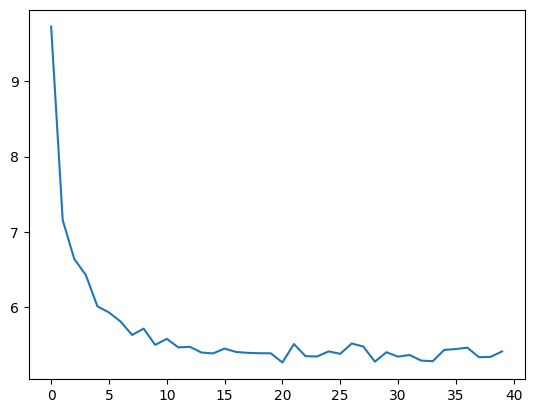

In [129]:
cEvent2CEventModel.train(trainDLCevent, 1000)

In [130]:
perplexityScore = cEvent2CEventModel.evaluateCEventPerplexity(testPairsCEvent, cEventVocab)

In [131]:
print(perplexityScore)

1.0478092733391324


In [132]:
BLEUScore = cEvent2CEventModel.evaluateBLEU(testPairsCEvent, cEventVocab)

In [133]:
print(BLEUScore)

0.05051696794069422


### Model for CEvent2Sentence

We take again the BART transformers that we fine tune to generate sentence from CEvent.

In [134]:
trainCEvent2Sent = {**trainPromptCEvent2Sent,**trainStoriesCEvent2Sent}

In [135]:
ind = random.choices(list(trainCEvent2Sent.keys()), k=maxExemples)
trainCEvent2SentHandle = {}
for i in ind:
  trainCEvent2SentHandle[i] = trainCEvent2Sent[i]

In [136]:
trainCEvent2SentList = []
for event in trainCEvent2SentHandle.keys():
  trainCEvent2SentList += [{"input": event.toStringNoComa(), "output": trainCEvent2SentHandle[event]}]

trainCEventDataset = Dataset.from_list(trainCEvent2SentList)


In [137]:
# Tokenize the data
def preprocess_CEvent_function(example):
    inputs = example["input"]
    targets = example["output"]
    model_inputs = tokenizerBART(inputs, max_length=maxCEventToken, truncation=True, padding="max_length")

    # Set up the tokenizer for targets
    labels = tokenizerBART(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenizedTrainCEventDataset = trainCEventDataset.map(preprocess_function, batched=False)

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

In [138]:
class CEvent2Sent():
  def __init__(self):
    # Load the BART model
    self.event2SentModel = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

  def setupTrainingParam(self, output_dir='./results', num_train_epochs=3, per_device_train_batch_size=8, per_device_eval_batch_size=8, warmup_steps=500, weight_decay=0.01, logging_dir='./logs', logging_steps=10):
    # Set up training arguments
    self.training_args = Seq2SeqTrainingArguments(
    output_dir= output_dir,          # output directory
    num_train_epochs=num_train_epochs,              # number of training epochs
    per_device_train_batch_size=per_device_train_batch_size,   # batch size for training
    per_device_eval_batch_size=per_device_eval_batch_size,    # batch size for evaluation
    warmup_steps=warmup_steps,                # number of warmup steps for learning rate scheduler
    weight_decay=weight_decay,               # strength of weight decay
    logging_dir=logging_dir,            # directory for storing logs
    logging_steps=logging_steps,
    )

  def fit(self, tokenizedTrainDataset):
    # Set up the Trainer
    self.trainer = Seq2SeqTrainer(
        model=self.event2SentModel,
        args=self.training_args,
        train_dataset=tokenizedTrainDataset,
    )

  def train(self):
    # Fine-tune the model
    self.trainer.train()

  def generate_output(self, input_text, maxCEventToken):
    inputs = tokenizerBART(input_text, return_tensors="pt", padding="max_length", max_length=maxCEventToken, truncation=True)
    outputs = self.event2SentModel.generate(inputs["input_ids"], max_length=50)
    output_text = tokenizerBART.decode(outputs[0], skip_special_tokens=True)
    return output_text

  def evaluateSentencePerplexity(self, testSet, vocab, maxCEventToken):
    perplexityScore = 0
    for event in testSet.keys():
        prediction = self.generate_output(event.toStringNoComa(), maxCEventToken)
        perplexityScore += perplexity(prediction, vocab)
    return perplexityScore / len(testSet)

  def evaluateBLEU(self, testSet, maxCEventToken):
    total_bleu_score = 0
    for event in testSet.keys():
        prediction = self.generate_output(event.toStringNoComa(), maxCEventToken)
        bleu_score = tr.bleu_score.sentence_bleu([testSet[event]], prediction, smoothing_function=tr.bleu_score.SmoothingFunction().method1)
        total_bleu_score += bleu_score

    return total_bleu_score / len(testSet)

In [139]:
cEvent2SentenceGenerator = CEvent2Sent()

In [140]:
cEvent2SentenceGenerator.setupTrainingParam()

In [141]:
cEvent2SentenceGenerator.fit(tokenizedTrainCEventDataset)

In [142]:
cEvent2SentenceGenerator.train()

Step,Training Loss
10,15.116800
20,14.141300


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


### Evaluation

In [143]:
testCEvent2Sent = {**testPromptCEvent2Sent,**testStoriesCEvent2Sent}
ind = random.choices(list(testCEvent2Sent.keys()), k=int(maxExemples*0.2))
testCEvent2SentHandle = {}
for i in ind:
  testCEvent2SentHandle[i] = testCEvent2Sent[i]

In [144]:
perp = cEvent2SentenceGenerator.evaluateSentencePerplexity(testCEvent2SentHandle, vocab, maxCEventToken)

In [145]:
print(perp)

1.3849278355294001


In [146]:
average_bleu_score = cEvent2SentenceGenerator.evaluateBLEU(testCEvent2SentHandle, maxCEventToken)
print(f"Average BLEU Score: {average_bleu_score}")

Average BLEU Score: 0.0758257392755145


### Final story generation (experimental)

In [156]:
class StoryGenerator():
  def __init__(self, cEvent2CEvent, cEvent2Sentence):
    self.cEvent2CEvent = cEvent2CEvent
    self.cEvent2Sentence = cEvent2Sentence

  def storyGeneration(self, vocab, startSentence, storyLength):
      vocab.addSentence(startSentence)
      outputStory = startSentence
      _, startEvents = cEventCreator(startSentence)
      startEvent = startEvents[0]
      inpTensor = tensorFromEvent(vocab, startEvent)
      inputTensor = torch.zeros(maxCEventToken, dtype=torch.int32)
      inputTensor[:min(len(inpTensor),maxCEventToken)] = inpTensor[:min(len(inpTensor),maxCEventToken)].squeeze()
      outputEvents = startEvent.toStringNoComa()
      print(inputTensor)
      for i in range(storyLength):
          outputStory += '\n'
          outputTensor = self.cEvent2CEvent.makePrediction(inputTensor)
          strEvent = sentenceFromTensor(vocab, outputTensor)
          strEvent = " ".join(strEvent)
          outputEvents += ' ' + strEvent
          outputSentence = self.cEvent2Sentence.generate_output(strEvent, maxCEventToken)
          outputStory += outputSentence
          inputTensor = outputTensor
      return outputEvents, outputStory

In [157]:
storyGenerator = StoryGenerator(cEvent2CEventModel, cEvent2SentenceGenerator)

In [162]:
ouputEvents, outputStory = storyGenerator.storyGeneration(vocab, 'earth is a red egg', 20)

tensor([1759,    2, 5873,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=torch.int32)


In [163]:
print(outputStory)

earth is a red egg
with flower so NoObject pungent NoObject NoObject noObject No Object NoObject YesObject NoNoObject No
with flower so NoObject pungent NoObject NoNoObject NoObject noObject No Object NoObject YesObject Noobject No
withholding so NoObject pungent NoObject No Object NoObject object NoObject PungentNoObject NoObjects NoObject YesObject NObject No
with flower so NoObject pungent NoNoObject NoObject No Object NoObjects NoObject nObject Noobject NoObject noObject No
with flower so NoObject pungent NoObject NoObject noObject No Object NoObject NObject Noobject NoObjectNoObject No
with flower so NoObject pungent NoObject NoObject YesObject No Object NoObject NObject NoNo Object Noobject NoNoobject NoObjectNoObject Noobject YesNo NoObject Object NoNoNoNoObject Yes NoObject
with Object NoObject No Object No Object Object Object Noobject No ObjectNoObject NoObjects NoObject YesObject Yes Object No NoObject Object No object No Object
with flower so NoObject pungent NoObject No Ob